### This notebook generates the moisture-precip relationships for MCSs in the idealized RCE simulations.

In [1]:
import numpy as np
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from matplotlib import cm

from scipy.optimize import curve_fit

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

# colorblind friendly colormap
CB_color_cycle = [ '#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3',
                   '#999999', '#e41a1c', '#dede00']

## Loading RCE data

In [2]:
path = '/xdisk/sylvia/RCE-CAPE-exploration/'
ssts = np.arange( 280, 315, 5 )

mean_280 = xr.open_dataset( path + 'RCE_COL_MEAN_280.nc' )
#mean_285 = xr.open_dataset( path + 'RCE_COL_MEAN_285.nc' )
#mean_290 = xr.open_dataset( path + 'RCE_COL_MEAN_290.nc' )
#mean_295 = xr.open_dataset( path + 'RCE_COL_MEAN_295.nc' )
#mean_300 = xr.open_dataset( path + 'RCE_COL_MEAN_300.nc' )
#mean_305 = xr.open_dataset( path + 'RCE_COL_MEAN_305.nc' )
#mean_310 = xr.open_dataset( path + 'RCE_COL_MEAN_310.nc' )

max_280 = xr.open_dataset( path + 'RCE_COL_MAX_280.nc' )
#max_285 = xr.open_dataset( path + 'RCE_COL_MAX_285.nc' )
#max_290 = xr.open_dataset( path + 'RCE_COL_MAX_290.nc' )
#max_295 = xr.open_dataset( path + 'RCE_COL_MAX_295.nc' )
#max_300 = xr.open_dataset( path + 'RCE_COL_MAX_300.nc' )
#max_305 = xr.open_dataset( path + 'RCE_COL_MAX_305.nc' )
#max_310 = xr.open_dataset( path + 'RCE_COL_MAX_310.nc' )

p95_280 = xr.open_dataset( path + 'RCE_COL_95_280.nc' )
#p95_285 = xr.open_dataset( path + 'RCE_COL_95_285.nc' )
#p95_290 = xr.open_dataset( path + 'RCE_COL_95_290.nc' )
#p95_295 = xr.open_dataset( path + 'RCE_COL_95_295.nc' )
#p95_300 = xr.open_dataset( path + 'RCE_COL_95_300.nc' )
#p95_305 = xr.open_dataset( path + 'RCE_COL_95_305.nc' )
#p95_310 = xr.open_dataset( path + 'RCE_COL_95_310.nc' )

p99_280 = xr.open_dataset( path + 'RCE_COL_99_280.nc' )
#p99_285 = xr.open_dataset( path + 'RCE_COL_99_285.nc' )
#p99_290 = xr.open_dataset( path + 'RCE_COL_99_290.nc' )
#p99_295 = xr.open_dataset( path + 'RCE_COL_99_295.nc' )
#p99_300 = xr.open_dataset( path + 'RCE_COL_99_300.nc' )
#p99_305 = xr.open_dataset( path + 'RCE_COL_99_305.nc' )
#p99_310 = xr.open_dataset( path + 'RCE_COL_99_310.nc' )

In [ ]:
means = [ mean_280, mean_285, mean_290, mean_295 ]#, mean_300, mean_305, mean_310 ]
maxes = [ max_280, max_285, max_290, max_295 ]#, max_300, max_305, max_310 ]
p95s = [ p95_280, p95_285, p95_290, p95_295 ]#, p95_300, p95_305, p95_310 ]
p99s = [ p99_280, p99_285, p99_290, p99_295 ]#, p99_300, p99_305, p99_310 ]

data_mean = xr.combine_nested( means, concat_dim='clusters' )
data_max = xr.combine_nested( maxes, concat_dim='clusters' )
data_p95 = xr.combine_nested( p95s, concat_dim='clusters' )
data_p99 = xr.combine_nested( p99s, concat_dim='clusters' )

In [3]:
display( mean_280 )
#display( data_mean )

<xarray.Dataset>
Dimensions:   (clusters: 710, z: 64)
Coordinates:
  * clusters  (clusters) float64 7.002e+04 7.009e+04 ... 7.968e+05 7.974e+05
  * z         (z) float32 37.0 112.0 194.0 ... 2.696e+04 2.746e+04 2.796e+04
Data variables:
    p_rate    (clusters) float64 ...
    CAPE      (clusters) float32 ...
    cwvc      (clusters) float32 ...
    csf       (clusters) float32 ...
    SD        (clusters) float32 ...
    omega     (clusters, z) float32 ...
    TABS      (clusters, z) float32 ...
    QV        (clusters, z) float32 ...
    p         (clusters, z) float32 ...

In [4]:
raw_file = xr.open_dataset( path + 'RCE-sims/ch_cam280ri0/ch_cam280ri0_4096x64x64_3km_12s_cam280ri0_64_0000023400.nc' )
display( raw_file )

<xarray.Dataset>
Dimensions:  (x: 4096, y: 64, z: 64, time: 1)
Coordinates:
  * x        (x) float32 0.0 3e+03 6e+03 9e+03 ... 1.228e+07 1.228e+07 1.228e+07
  * y        (y) float32 0.0 3e+03 6e+03 9e+03 ... 1.83e+05 1.86e+05 1.89e+05
  * z        (z) float32 37.0 112.0 194.0 ... 2.696e+04 2.746e+04 2.796e+04
  * time     (time) float32 83.75
Data variables: (12/13)
    p        (z) float32 ...
    zi       (z) float32 ...
    U        (time, z, y, x) float32 ...
    V        (time, z, y, x) float32 ...
    W        (time, z, y, x) float32 ...
    PP       (time, z, y, x) float32 ...
    ...       ...
    TABS     (time, z, y, x) float32 ...
    QV       (time, z, y, x) float32 ...
    QN       (time, z, y, x) float32 ...
    QP       (time, z, y, x) float32 ...
    LQRAD    (time, z, y, x) float32 ...
    SQRAD    (time, z, y, x) float32 ...

## Figure 4 - Joint distribution of CSF and MCS precip

In [11]:
def scatter_hist(x, y, xbins, ybins, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    h = ax.hist2d( x, y, bins=(xbins, ybins), cmap=cm.Blues )
    wgts = np.ones_like(x)/float(len(x))*100
    ax_histx.hist(x, bins=xbins, edgecolor='k', weights=wgts )
    ax_histx.tick_params(axis='both', which='major', labelsize=12)
    wgts = np.ones_like(y)/float(len(y))*100
    ax_histy.hist(y, bins=ybins, edgecolor='k', weights=wgts, orientation='horizontal')
    ax_histy.tick_params(axis='both', which='major', labelsize=12)
    ax_histy.set_yscale('log')
    return h

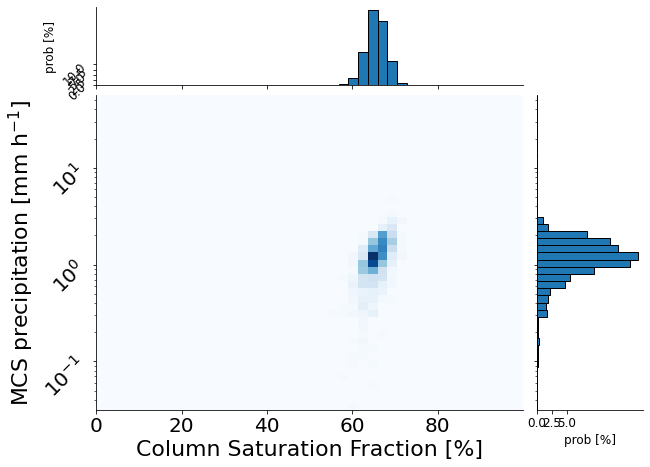

In [13]:
fig = plt.figure( figsize=(9.5, 7) )
font_size = 20
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size+2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})

csf_RCE = mean_280.csf
pmean_RCE = mean_280.p_rate
i = np.where( (~np.isnan(csf_RCE)) & (~np.isnan(pmean_RCE)) )

gs = fig.add_gridspec( 2, 2, width_ratios=(4, 1), height_ratios=(1, 4), left=0.1, right=0.9, bottom=0.1, top=0.9,
                     wspace=0.05, hspace=0.05 )
ax = fig.add_subplot(gs[1,0])
ax_histx = fig.add_subplot( gs[0,0], sharex=ax )
ax_histy = fig.add_subplot( gs[1,1], sharey=ax )
xbins = np.linspace( 0, 100, 45 )
ybins = np.logspace( -1.5, 1.75, 45 )
h = scatter_hist( csf_RCE[i]*100, pmean_RCE[i], xbins, ybins, ax, ax_histx, ax_histy )

ax.set_xticks( [0, 20, 40, 60, 80] )
ax_histx.set_ylabel( 'prob [%]', fontsize=12 )
ax_histx.set_yticks( [0, 2.5, 5, 7.5, 10], rotation=45 )
ax_histy.set_xlabel( 'prob [%]', fontsize=12 )
ax_histy.set_xticks( [0, 2.5, 5], rotation=45 )
ax.set_ylabel( 'MCS precipitation [mm h$^{-1}$]' )
ax.set_xlabel( 'Column Saturation Fraction [%]' )

for a in ax, ax_histx, ax_histy:
    a.spines['top'].set_visible( False )
    a.spines['right'].set_visible( False )
    for t in a.get_yticklabels():
        t.set_rotation(45)
        
plt.tight_layout()
#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/csf-precip-ERAI.pdf', bbox_inches='tight' )
plt.show()

## Figure 5 - CSF-precip relationship for MCS across percentiles

In [15]:
mean_RCE = [ mean_280 ]#, mean_285, mean_290, mean_295 ]
cwvc_bins_list = [ [], [], [], [] ]
csf_bins_list = [ [], [], [], [] ]

pmax_list = [ [], [], [], [] ]
pmax_95_list = [ [], [], [], [] ]
pmax_99_list = [ [], [], [], [] ]
pmax_max_list = [ [], [], [], [] ]

pmax_list2 = [ [], [], [], [] ]
pmax_95_list2 = [ [], [], [], [] ]
pmax_99_list2 = [ [], [], [], [] ]
pmax_max_list2 = [ [], [], [], [] ]

cwvc_error_list = [ [], [], [], [] ]
pmax_error_list = [ [], [], [], [] ]

In [16]:
for iterator, mean_array in enumerate(mean_RCE):
    csf_RCE = mean_array['csf'].to_numpy()
    cwvc_RCE = mean_array['cwvc'].to_numpy()
    pmax_RCE = mean_array['p_rate'].to_numpy()
    cwvc_min = np.nanmin( cwvc_RCE )
    cwvc_max = np.nanmax( cwvc_RCE )
    cwvc_bins, pmean_vals, pmean_95_vals, pmean_99_vals, cwvc_error, pmean_error, cwvc_max, pmean_max = \
        bin_stat_function( 35, cwvc_min, cwvc_max, cwvc_RCE, pmean_RCE, threshold=10 )
    
    cwvc_bins_list[iterator] = cwvc_bins
    pmax_list[iterator] = pmax_bins
    pmax_95_list[iterator] = pmax_95_bins
    pmax_99_list[iterator] = pmax_99_bins
    pmax_max_list[iterator] = p_max
    
    cwvc_error_list[iterator] = cwvc_error
    pmax_error_list[iterator] = pmax_error
    
    csf_bins, pmean_vals2, pmean_95_vals2, pmean_99_vals2, csf_error, pmean_error2, csf_max, pmean_max2 = \
        bin_stat_function( 35, 0, 100, csf_RCE, pmean_ERAI, threshold=100 )

IndexError: too many indices for array: array is 1-dimensional, but 5 were indexed

In [ ]:
cwvc_280_RCE = mean_280['cwvc'].to_numpy()
pmax_280_RCE = mean_280['p_rate'].to_numpy()
cwvc_280_min = np.nanmin( cwvc_280_RCE )
cwvc_280_max = np.nanmax( cwvc_280_RCE )
cwvc_280_bins, pmax_280_bins, pmax_280_95_bins, pmax_280_99_bins, cwvc_280_error, pmax_280_error, cwvc_280_max, p_280_max = \
    bin_stat_function( 35, cwvc_280_min, cwvc_280_max, cwvc_280_RCE, pmax_280_RCE, threshold=10 )

In [ ]:
cwvc_285_RCE = mean_285['cwvc'].to_numpy()
pmax_285_RCE = mean_285['p_rate'].to_numpy()
cwvc_285_min = np.nanmin( cwvc_285_RCE )
cwvc_285_max = np.nanmax( cwvc_285_RCE )
cwvc_285_bins, pmax_285_bins, pmax_285_95_bins, pmax_285_99_bins, cwvc_285_error, pmax_285_error, cwvc_285_max, p_285_max = \
    bin_stat_function( 35, cwvc_285_min, cwvc_285_max, cwvc_285_RCE, pmax_285_RCE, threshold=10 )

In [ ]:
cwvc_290_RCE = mean_290['cwvc'].to_numpy()
pmax_290_RCE = mean_290['p_rate'].to_numpy()
cwvc_290_min = np.nanmin( cwvc_290_RCE )
cwvc_290_max = np.nanmax( cwvc_290_RCE )
cwvc_290_bins, pmax_290_bins, pmax_290_95_bins, pmax_290_99_bins, cwvc_290_error, pmax_290_error, cwvc_285_max, p_285_max = \
    bin_stat_function( 35, cwvc_285_min, cwvc_285_max, cwvc_285_RCE, pmax_285_RCE, threshold=10 )

In [ ]:
fig, ax = plt.subplots( 2, 2, figsize =(11, 8) )

ylab = [ r'Mean $\dot{P}$ [mm h$^{-1}$]', r'95th percentile $\dot{P}$ [mm h$^{-1}$]', r'99th percentile $\dot{P}$ [mm h$^{-1}$]',\
             r'Max $\dot{P}$ [mm h$^{-1}$]' ]
labels = [ '', '' , 'Column Water Vapor Content [mm]', 'Column Water Vapor Content [mm]' ]
let = [ '(a)', '(b)', '(c)', '(d)' ]
font_size = 15
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size+2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})

for i, axis in enumerate(ax.flat): 
    axis.set( ylabel = ylab[i] )
    #axis.set_xlim( [0, 100] )
    axis.spines['top'].set_visible( False )
    axis.spines['right'].set_visible( False )
    axis.set( xlabel = labels[i] )
    for t in axis.get_yticklabels():
        t.set_rotation(45)
    axis.text( 0.05, 0.95, let[i], transform=axis.transAxes, fontsize=font_size+3, weight='bold' )
    
    if i == 0:
        for j, k, l, m, n in zip(cwvc_bins_list, pmax_list, np.arange(len(cwvc_bins_list)), cwvc_error_list, pmax_error_list):
            axis.scatter( j, k, color = CB_color_cycle[l] )
            axis.errorbar( j, k, xerr=m/2, yerr=n/2, color = CB_color_cycle[l], ls='none' )
        axis.set_ylim( [0, 8] )
    elif i == 1:
        for j, k, l in zip(cwvc_bins_list, pmax_95_list, np.arange(len(cwvc_bins_list))):
            axis.scatter( j, k, color = CB_color_cycle[l])
        axis.set_ylim( [0, 8] )
    #elif i == 3:
    #    axis.scatter( csf_max.flatten(), p_max_2.flatten(), color = 'blue' )
    #    axis.set_ylim([0, 200])
    else:
        for j, k, l in zip(cwvc_bins_list, pmax_99_list, np.arange(len(cwvc_bins_list))):
            axis.scatter( j, k, color = CB_color_cycle[l])
        #axis.set_ylim([0, 200])

plt.tight_layout()
#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/csf-precip-ERAI.pdf', bbox_inches='tight' )
#plt.show()

## Figure 6 - Saturation deficit-CAPE relationship across percentiles

## Figure 9 - Pressure velocity-CAPE conversion

## Figure 12 - precip efficiency from integrated cond rate scaling